In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import math
from lmfit import Model, Parameters
import matplotlib as mpl
from scipy import stats

mpl.rcParams['pdf.fonttype'] = 42


In [276]:
plt.rcParams.update({
    'font.size': 16,          # 默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 33,    # x轴刻度标签字体大小
    'ytick.labelsize': 33,    # y轴刻度标签字体大小
    'legend.fontsize': 16     # 图例字体大小
})


# 数据导入

In [ ]:
df = pd.read_excel('../../data/cases by cities/合肥市逐周病例统计.xlsx')
df

,Date,Case
0,2023-01-01,0
1,2023-01-08,0
2,2023-01-15,0
3,2023-01-22,0
4,2023-01-29,0
...,...,...
260,2020-12-02,0
261,2020-12-09,0
262,2020-12-16,0
263,2020-12-23,0


In [278]:
import pandas as pd

# 假设你已经有一个名为 df 的 DataFrame
# 确保 'Date' 列是 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 获取所有年份
years = df['Date'].dt.year.unique()

# 创建每一年的 DataFrame
for year in years:
    globals()[f'df_{year}'] = df[df['Date'].dt.year == year]

# 现在你可以通过 df_2019、df_2020 等访问相应年份的数据

I_2019 = df_2019['Case']
I_2020 = df_2020['Case']
I_2021 = df_2021['Case']
I_2022 = df_2022['Case']
I_2023 = df_2023['Case']

# 数据拟合

## 2023

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 24
    # variables        = 4
    chi-square         = 549.312851
    reduced chi-square = 27.4656425
    Akaike info crit   = 83.1347433
    Bayesian info crit = 87.8469586
    R-squared          = 0.47582568
[[Variables]]
    beta0:  0.07959682 +/- 0.05156025 (64.78%) (init = 0.001)
    alpha:  1.82419883 +/- 8.21787448 (450.49%) (init = 2)
    T:      52 (fixed)
    S2_0:   95880.0138 +/- 119271.350 (124.40%) (init = 3000)
    S3_0:   1334.42500 +/- 9.4046e+11 (70476893165.61%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9857
    C(alpha, S3_0)  = +0.9721
    C(beta0, alpha) = -0.5754
    C(alpha, S2_0)  = +0.4803
    C(beta0, S3_0)  = -0.4063
    C(S2_0, S3_0)   = +0.2878
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # da

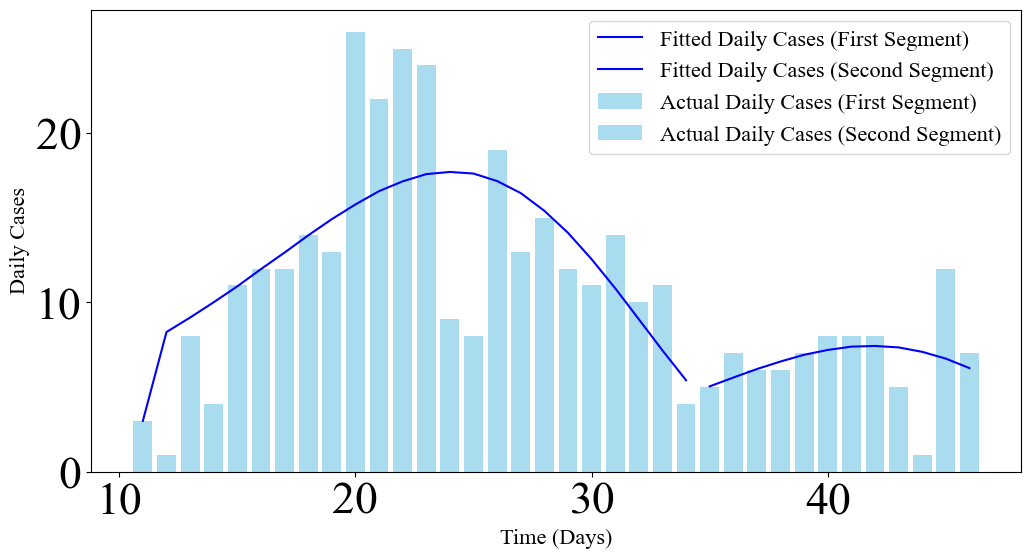

In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2023[10:34].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2023[34:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 35)  # 第一段48-236日
t_days_2 = np.arange(34, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(35, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 9852999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00798
    dr1 = 0.00616
    κ = 1
    p = 0.043
    f = 0.031496
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    9852999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00798
dr1 = 0.00616
κ = 1
p = 0.043
f = 0.031496
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00798
    dr1 = 0.00616
    κ = 1
    p = 0.043
    f = 0.031496
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2023 的中位数: 3.0638950316333116
R_2023 的中位数: 0.036510115001846616


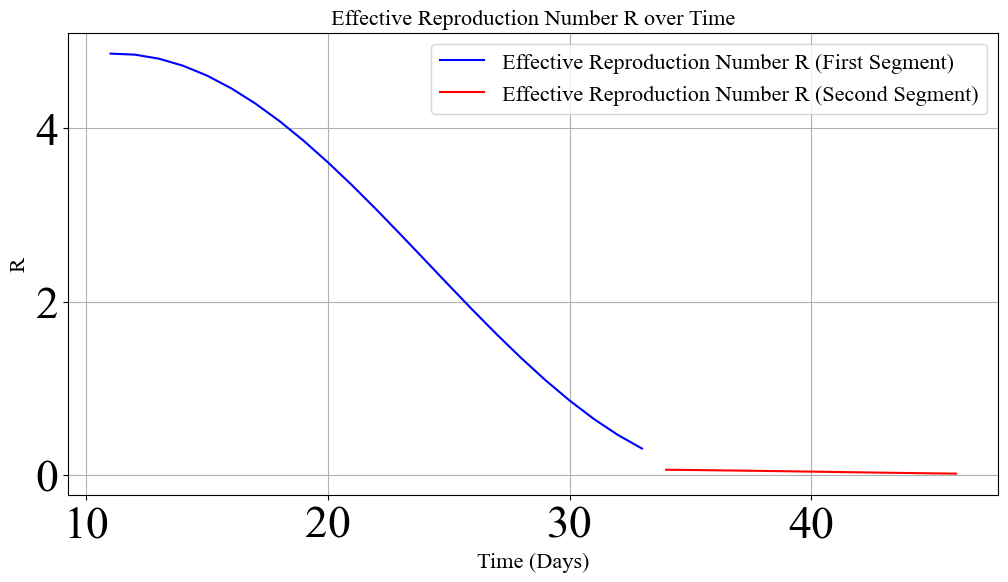

In [283]:
N1 = 9853000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 34)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2023 的中位数:", median_R_1)
print("R_2023 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2023 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2023 = I_2023[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2023# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2023  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 17.34902182469824
RMSE: 4.165215699660492
R-squared: 0.5528442558159035
MAE: 2.864191416150895
MAPE: 60.936294019963015%


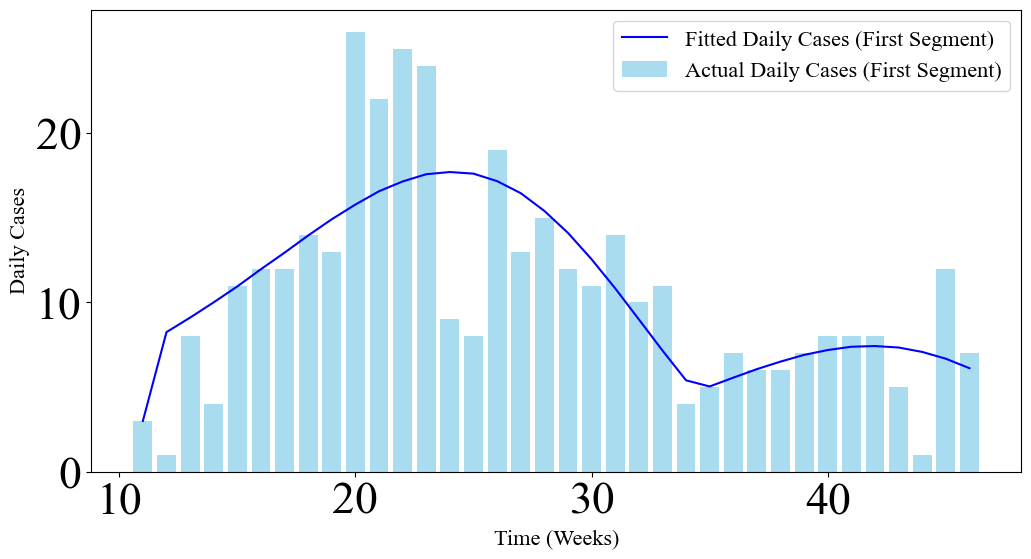

皮尔森相关系数：0.7443377998354828
p值：1.950035773039e-07


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2023, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2023, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Hefei/2023.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2023, result_2023)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

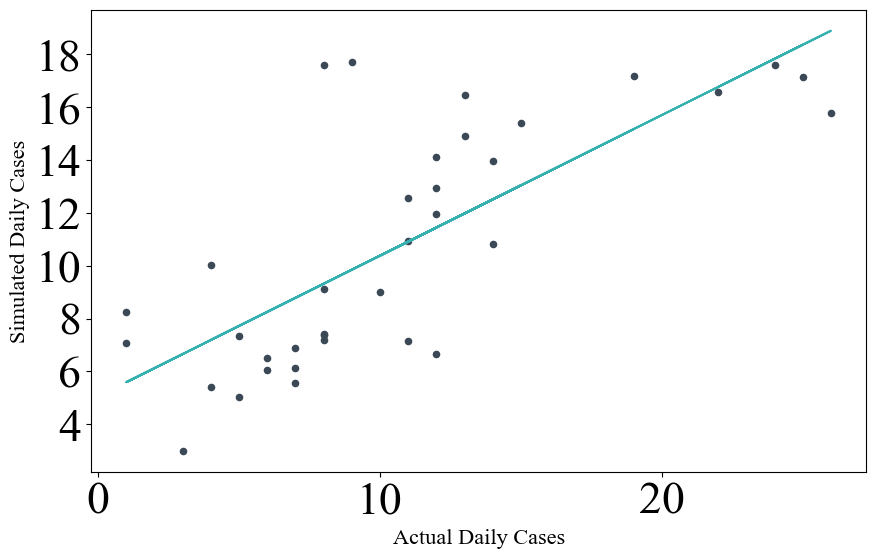

R²：0.5540387602639274


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2023)
predicted_cases = np.array(result_2023)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Hefei/2023.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

R_2023 的中位数: 1.2204817832659014
R_2023 的平均数为: 1.8527794593673843


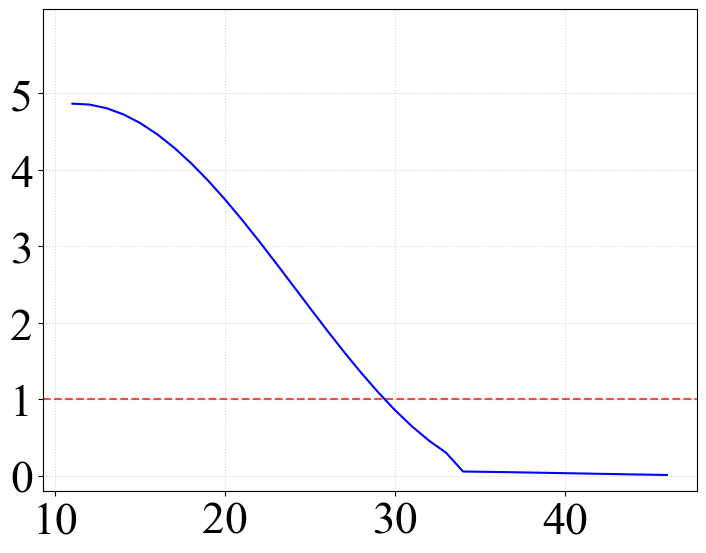

In [ ]:
R_2023 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2023).to_excel('../../outcome/Result/Fit/Hefei/R_2023.xlsx', index=False)

median_R_23 = statistics.median(R_2023)
print("R_2023 的中位数:", median_R_23)
average_R = np.mean(R_2023)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 6.1)
plt.yticks(np.arange(0, 5.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

plt.plot(np.arange(11, 47), R_2023, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Hefei/R_2023.pdf', format='pdf')
plt.show()

## 2022

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 22
    # variables        = 4
    chi-square         = 249.697217
    reduced chi-square = 13.8720676
    Akaike info crit   = 61.4425452
    Bayesian info crit = 65.8067150
    R-squared          = 0.36101678
[[Variables]]
    beta0:  0.05895340 +/- 0.04580235 (77.69%) (init = 0.001)
    alpha:  2.68256102 +/- 11.1270131 (414.79%) (init = 2)
    T:      52 (fixed)
    S2_0:   99369.6620 +/- 231560.793 (233.03%) (init = 3000)
    S3_0:   2897.75945 +/- 8.7664e+12 (302523562363.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9661
    C(beta0, S2_0)  = -0.9577
    C(beta0, alpha) = -0.2626
    C(S2_0, S3_0)   = +0.2068
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 112
    # data points      = 14
    # variables        = 3
    chi-squa

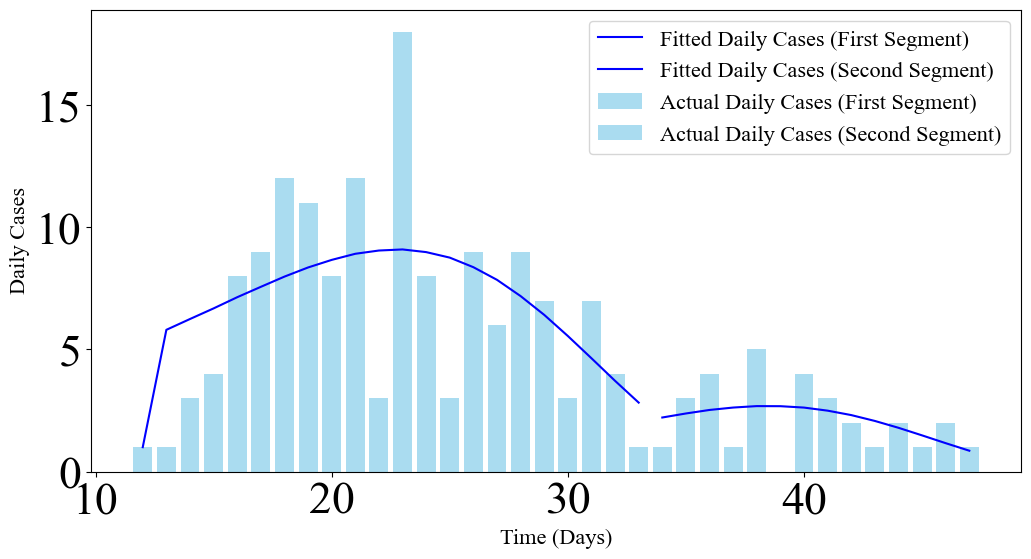

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2022[11:33].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2022[33:47].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(12, 34)  # 第一段48-236日
t_days_2 = np.arange(33, 48)  # 第二段拟合236-330日
t_days_3 = np.arange(34, 48)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 9633999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00897
    dr1 = 0.00539
    κ = 1
    p = 0.043
    f = 0.022599
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    9633999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00897
dr1 = 0.00539
κ = 1
p = 0.043
f = 0.022599
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00897
    dr1 = 0.00539
    κ = 1
    p = 0.043
    f = 0.022599
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2022 的中位数: 3.2015973438097665
R_2022 的中位数: 0.03046810189351194


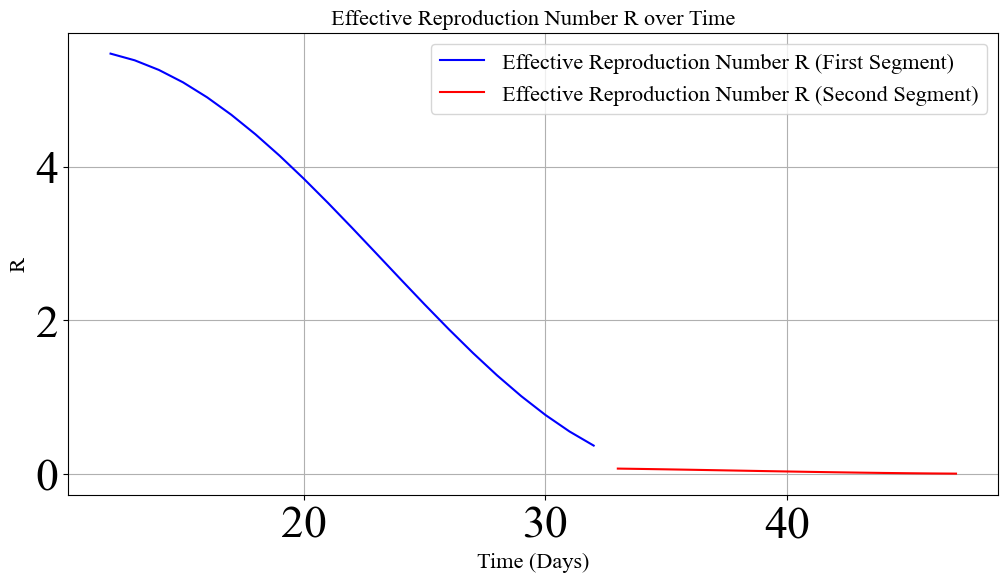

In [291]:
N1 = 9634000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(12, 33)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2022 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2022 的中位数:", median_R_1)
print("R_2022 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2022 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2022[47:329] 的数据
observed_cases_2022 = I_2022[11:47].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2022# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2022  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 7.592184803151799
RMSE: 2.7553919509122107
R-squared: 0.5404478303262468
MAE: 1.9977620283250976
MAPE: inf%


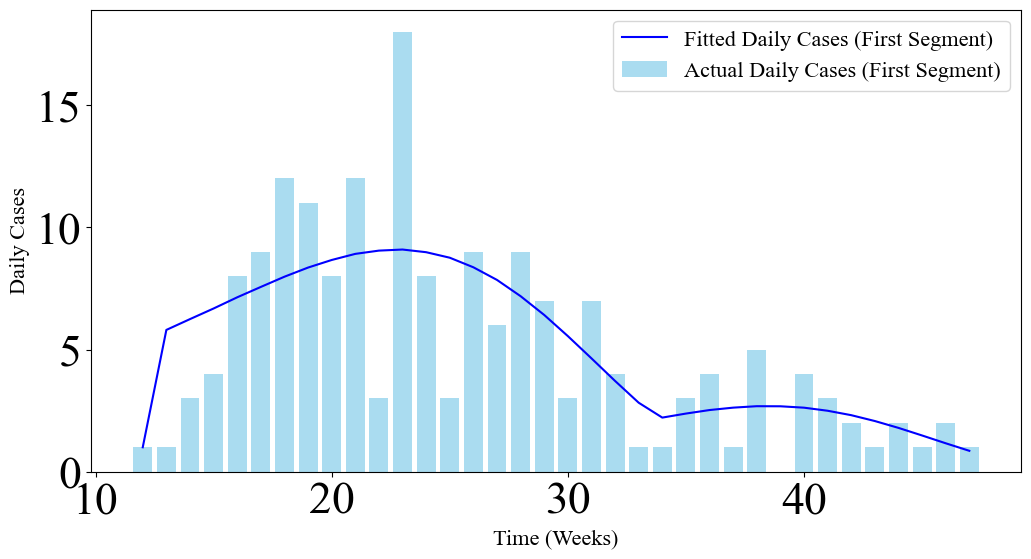

皮尔森相关系数：0.736186561986318
p值：3.101134118155016e-07


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(12, 48), observed_cases_2022, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(12, 48), result_2022, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Hefei/2022.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2022, result_2022)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

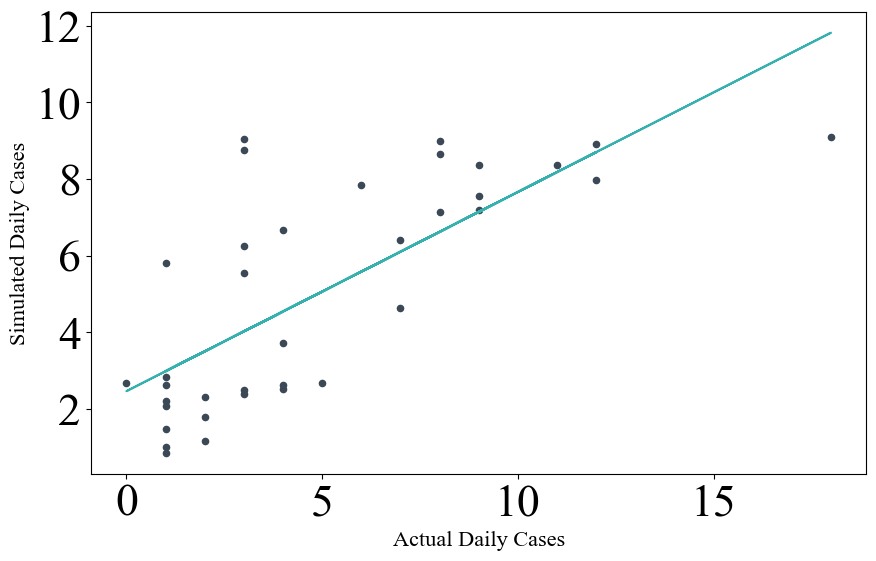

R²：0.5419706540492348


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2022)
predicted_cases = np.array(result_2022)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Hefei/2022.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.8892179170904867
R_2023 的平均数为: 1.8179418490647912


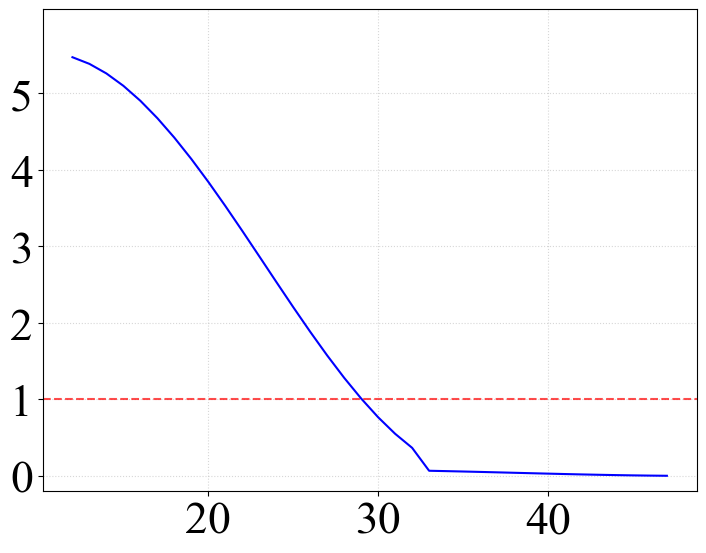

In [ ]:
R_2022 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2022).to_excel('../../outcome/Result/Fit/Hefei/R_2022.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2022)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2022)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 6.1)
plt.yticks(np.arange(0, 5.1, 1))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(12, 48), R_2022, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Hefei/R_2022.pdf', format='pdf')
plt.show()

## 2021

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 25
    # variables        = 4
    chi-square         = 155.317771
    reduced chi-square = 7.39608434
    Akaike info crit   = 53.6649333
    Bayesian info crit = 58.5404366
    R-squared          = 0.26039157
[[Variables]]
    beta0:  0.04127804 +/- 0.03155177 (76.44%) (init = 0.001)
    alpha:  2.49564160 +/- 10.1163993 (405.36%) (init = 2)
    T:      52 (fixed)
    S2_0:   99997.6347 +/- 170282.201 (170.29%) (init = 3000)
    S3_0:   1038.05308 +/- 2.5844e+09 (248970003.10%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = +0.9423
    C(beta0, S2_0)  = -0.9098
    C(S2_0, S3_0)   = -0.4827
    C(alpha, S2_0)  = -0.1995
    C(beta0, alpha) = -0.1528
    C(beta0, S3_0)  = +0.1138
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 172
    # data

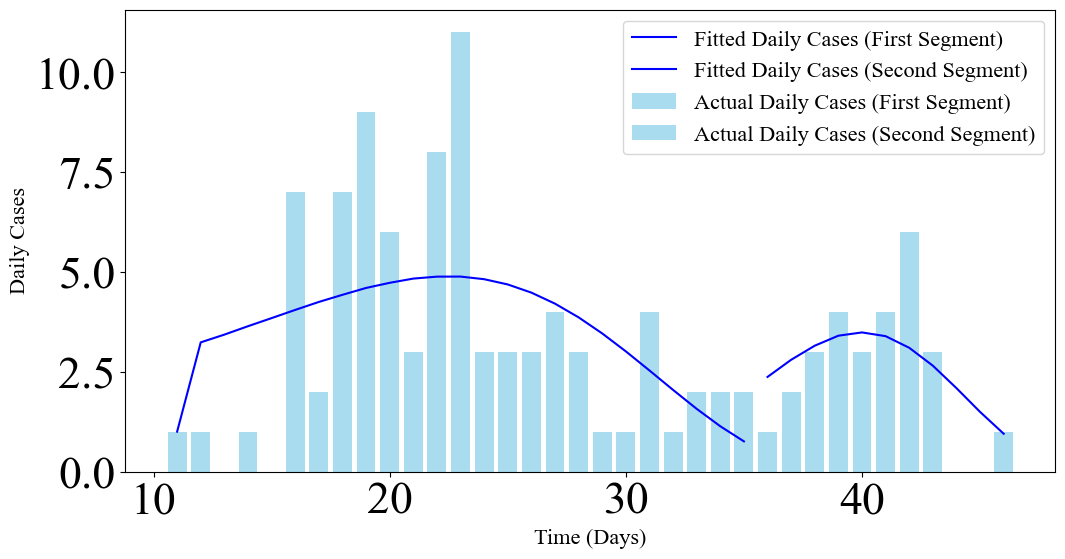

In [299]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2021[10:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2021[35:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 9464999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00904
    dr1 = 0.00532
    κ = 1
    p = 0.043
    f = 0.017857
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]


# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    9464999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00904
dr1 = 0.00532
κ = 1
p = 0.043
f = 0.017857
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00904
    dr1 = 0.00532
    κ = 1
    p = 0.043
    f = 0.017857
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2021 的中位数: 1.3254115829031836
R_2021 的中位数: 0.018683423604750247


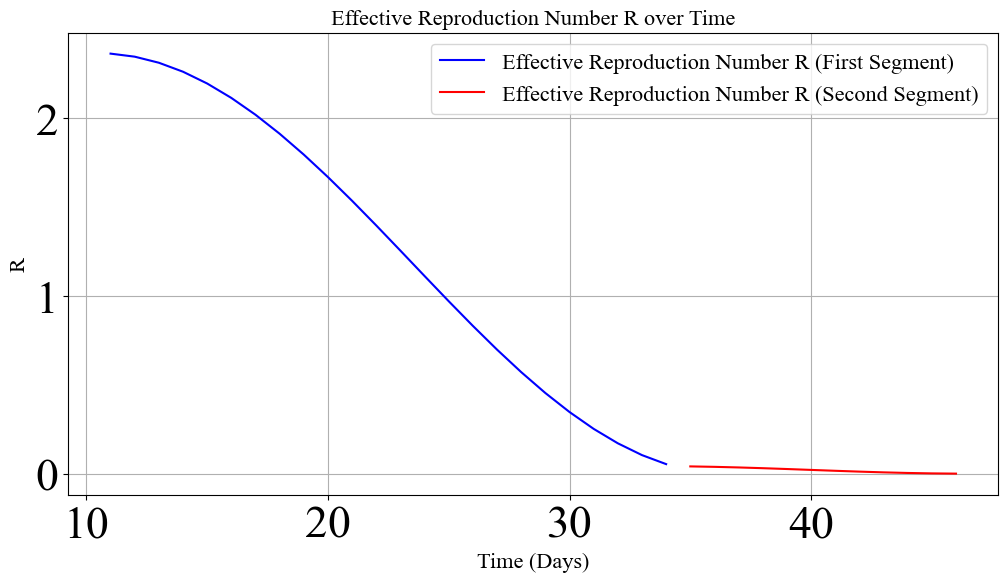

In [300]:
N1 = 9465000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2021 的中位数:", median_R_1)
print("R_2021 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2021 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2021 = I_2021[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2021# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2021  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 4.832133486431491
RMSE: 2.198211428964805
R-squared: 0.3084755964647513
MAE: 1.7528875265011545
MAPE: inf%


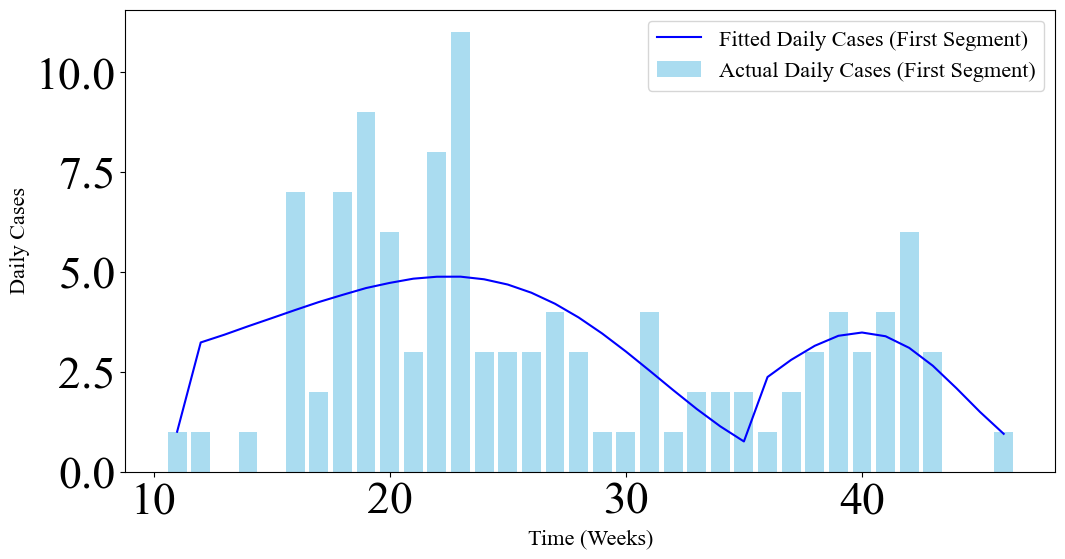

皮尔森相关系数：0.5672993781788243
p值：0.00030857421628000973


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2021, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2021, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Hefei/2021.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2021, result_2021)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

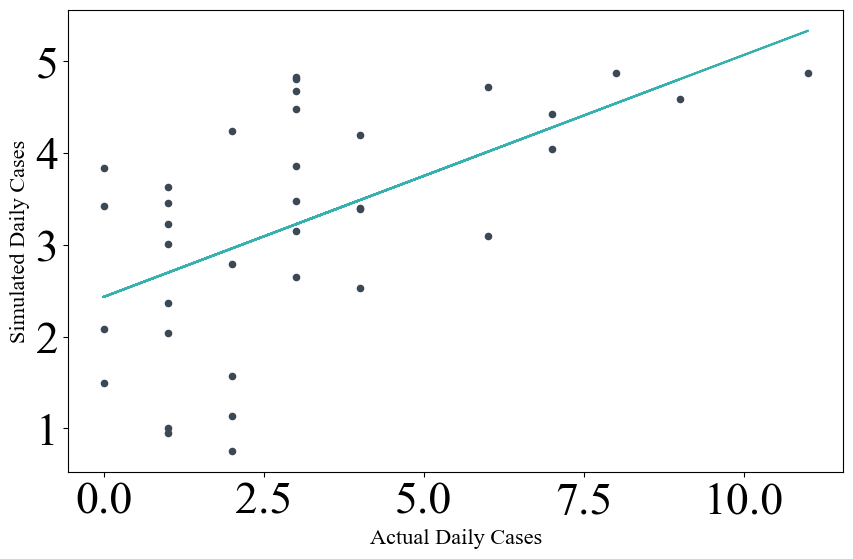

R²：0.3218285844820805


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2021)
predicted_cases = np.array(result_2021)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Hefei/2021.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.512508361344868
R_2023 的平均数为: 0.8602070724093198


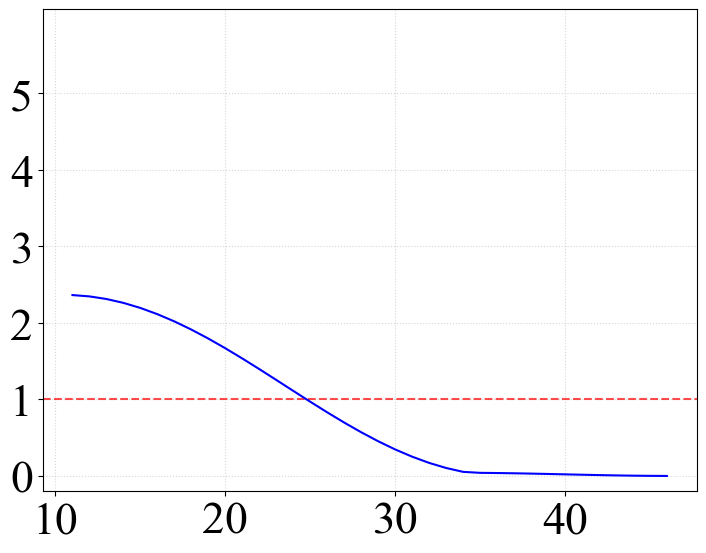

In [ ]:
R_2021 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2021).to_excel('../../outcome/Result/Fit/Hefei/R_2021.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2021)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2021)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 6.1)
plt.yticks(np.arange(0, 5.1, 1)) # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(11, 47), R_2021, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Hefei/R_2021.pdf', format='pdf')
plt.show()

## 2020

In [305]:
I_2020

212    0
213    0
214    0
215    0
216    0
217    0
218    0
219    0
220    0
221    1
222    0
223    0
224    2
225    2
226    7
227    2
228    4
229    3
230    4
231    9
232    6
233    5
234    6
235    6
236    5
237    5
238    7
239    4
240    6
241    6
242    6
243    3
244    0
245    3
246    1
247    0
248    1
249    2
250    1
251    0
252    5
253    2
254    2
255    0
256    0
257    0
258    0
259    0
260    0
261    0
262    0
263    0
264    0
Name: Case, dtype: int64

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 26
    # variables        = 4
    chi-square         = 76.0244435
    reduced chi-square = 3.45565652
    Akaike info crit   = 35.8969177
    Bayesian info crit = 40.9293039
    R-squared          = 0.49639859
[[Variables]]
    beta0:  0.03976920 +/- 0.02242271 (56.38%) (init = 0.001)
    alpha:  0.06272548 +/- 8.58518906 (13686.92%) (init = 2)
    T:      52 (fixed)
    S2_0:   99916.5462 +/- 136502.139 (136.62%) (init = 3000)
    S3_0:   1265.45507 +/- 6.6589e+12 (526205580139.93%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = +0.9722
    C(beta0, S2_0)  = -0.9054
    C(beta0, alpha) = -0.6954
    C(beta0, S3_0)  = -0.5552
    C(alpha, S2_0)  = +0.3731
    C(S2_0, S3_0)   = +0.1766
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 182
    #

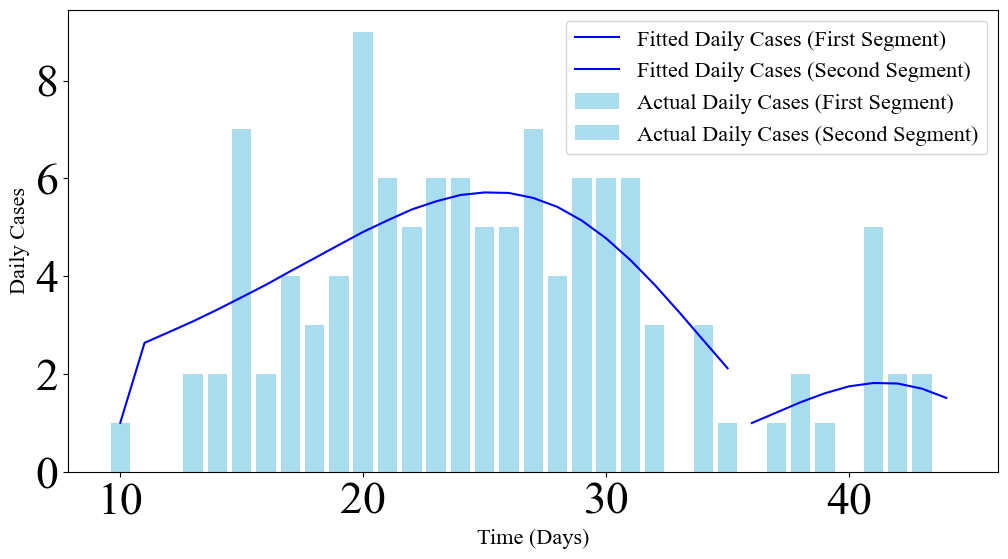

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2020[9:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2020[35:44].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(10, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 45)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 45)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 9373399  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01265
    dr1 = 0.00438
    κ = 1
    p = 0.043
    f = 0.0431034
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    9373399, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.01265
dr1 = 0.00438
κ = 1
p = 0.043
f = 0.0431034
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.01265
    dr1 = 0.00438
    κ = 1
    p = 0.043
    f = 0.0431034
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2020 的中位数: 1.8512010620279071
R_2020 的中位数: 0.02505677840233618


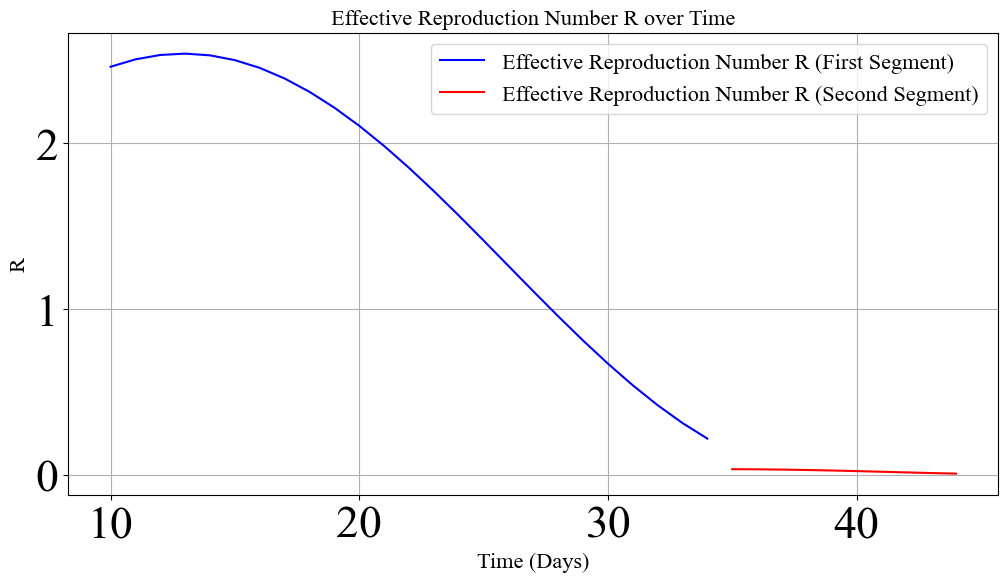

In [309]:
N1 = 9373400


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(10, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
print("R_2020 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2020 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2020 = I_2020[9:44].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2020# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2020  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.667575970622441
RMSE: 1.6332715544643643
R-squared: 0.5627802295942614
MAE: 1.2628231834375327
MAPE: inf%


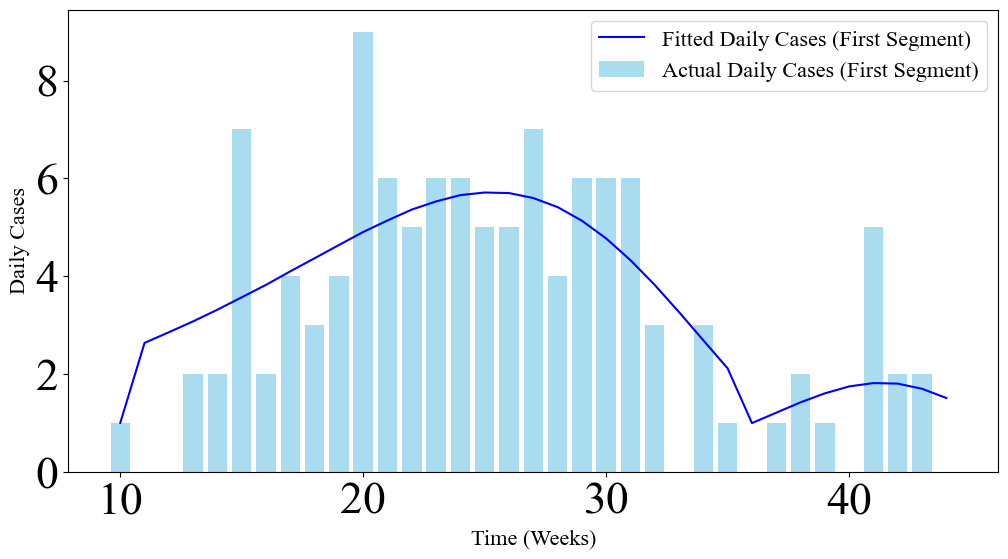

皮尔森相关系数：0.7634122418548599
p值：9.635039202373049e-08


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(10, 45), observed_cases_2020, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(10, 45), result_2020, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../结果图/拟合结果2/2020.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2020, result_2020)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

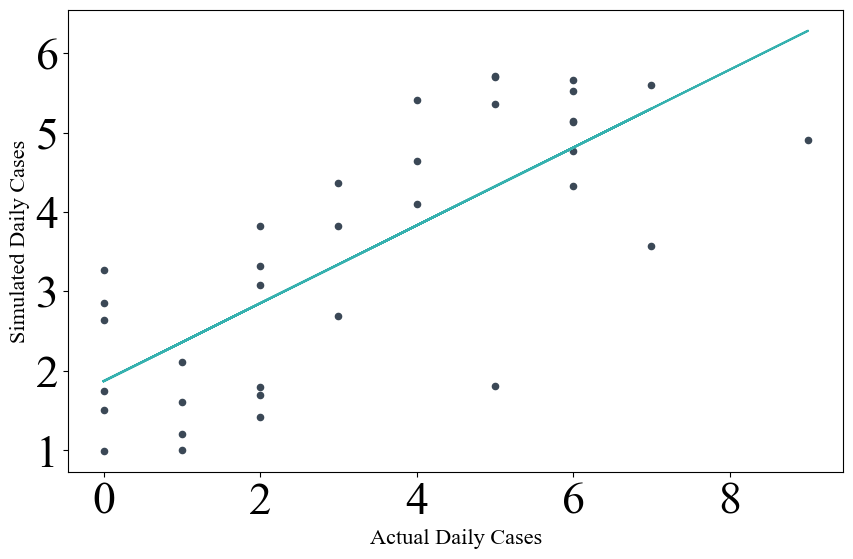

R²：0.582798251013863


In [312]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2020)
predicted_cases = np.array(result_2020)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../结果图/拟合结果2/拟合优度图/2020.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.1070939479241337
R_2023 的平均数为: 1.1883302562156413


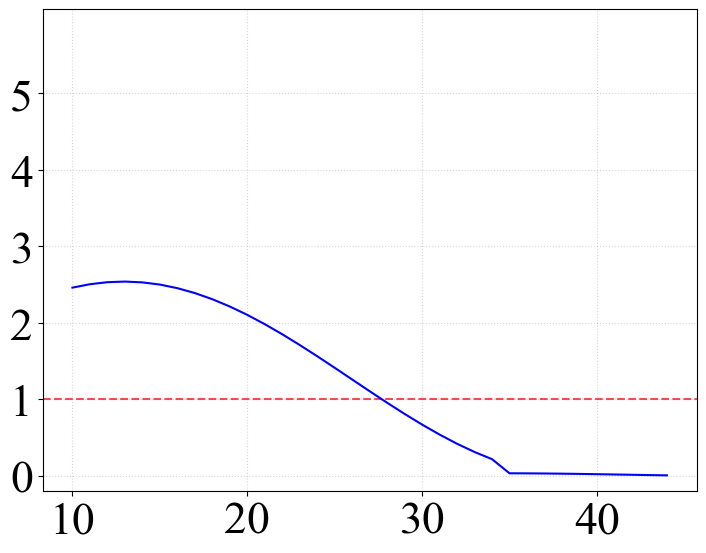

In [ ]:
R_2020 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2020).to_excel('../../结果图/拟合结果2/R_2020.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2020)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2020)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 6.1)
plt.yticks(np.arange(0, 5.1, 1)) # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(10, 45), R_2020, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Hefei/R_2020.pdf', format='pdf')
plt.show()

## 2019

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 24
    # variables        = 4
    chi-square         = 57.8346739
    reduced chi-square = 2.89173369
    Akaike info crit   = 29.1088318
    Bayesian info crit = 33.8210471
    R-squared          = 0.19487693
[[Variables]]
    beta0:  0.02337087 +/- 0.04363262 (186.70%) (init = 0.001)
    alpha: -1.31375605 +/- 32.2124903 (2451.94%) (init = 2)
    T:      52 (fixed)
    S2_0:   99857.7758 +/- 12678097.7 (12696.15%) (init = 5000)
    S3_0:   3070.51386 +/- 84130095.4 (2739935.38%) (init = 5000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9882
    C(beta0, alpha) = -0.9233
    C(beta0, S2_0)  = +0.9162
    C(beta0, S3_0)  = +0.8710
    C(alpha, S2_0)  = -0.7144
    C(S2_0, S3_0)   = +0.6123
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 159
    # da

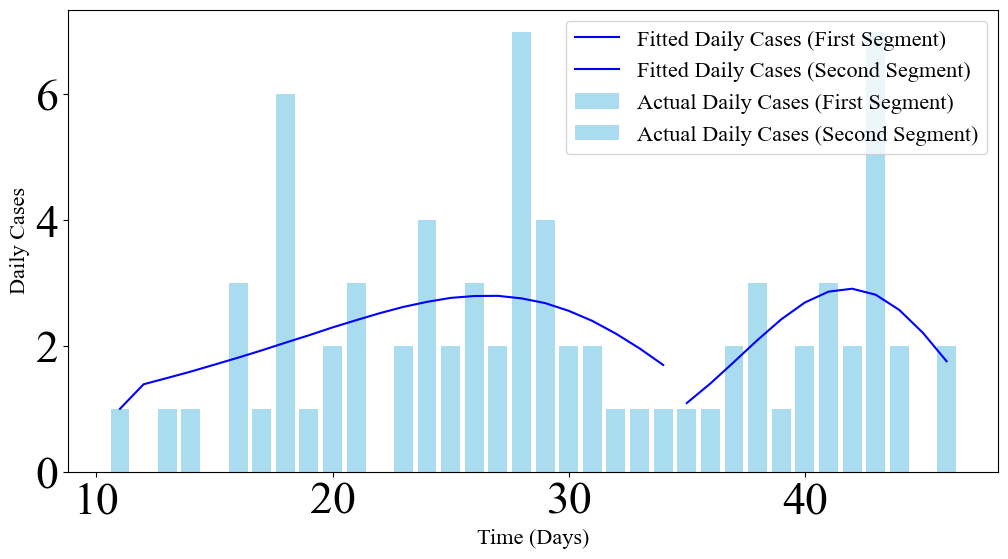

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2019[10:34].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2019[34:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 35)  # 第一段48-236日
t_days_2 = np.arange(34, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(35, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 8188999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01265
    dr1 = 0.00438
    κ = 1
    p = 0.043
    f = 0.105263
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=5000, min=3000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=5000, min=3000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    8188999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.01265
dr1 = 0.00438
κ = 1
p = 0.043
f = 0.105263
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.01265
    dr1 = 0.00438
    κ = 1
    p = 0.043
    f = 0.105263
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2020 的中位数: 2.126437521930407
R_2020 的中位数: 0.05503522066742248


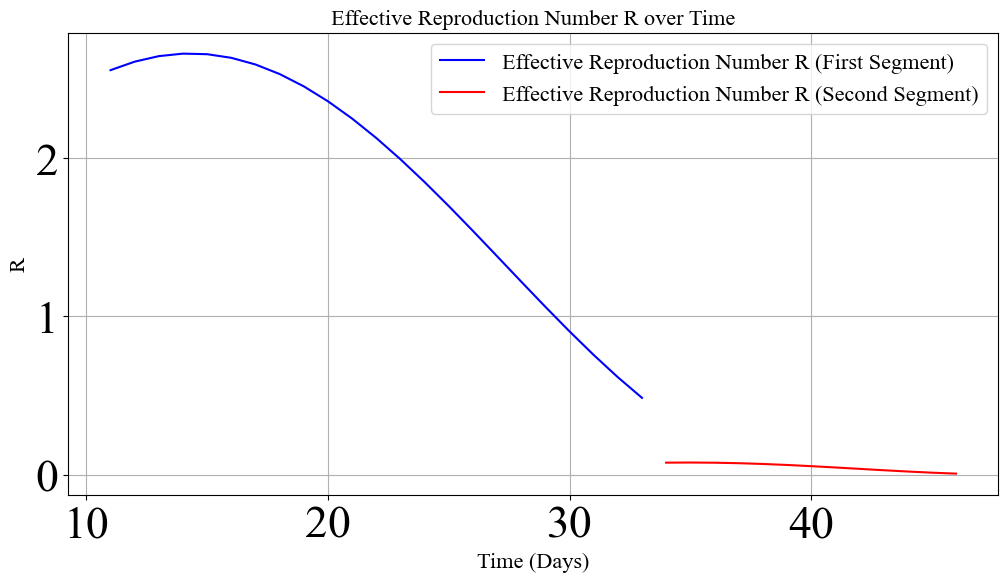

In [316]:
N1 = 8189000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 34)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
print("R_2020 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2019 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2019 = I_2019[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2019# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2019  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.3615823571398535
RMSE: 1.53674407665683
R-squared: 0.19457612240703936
MAE: 1.1081775805869332
MAPE: inf%


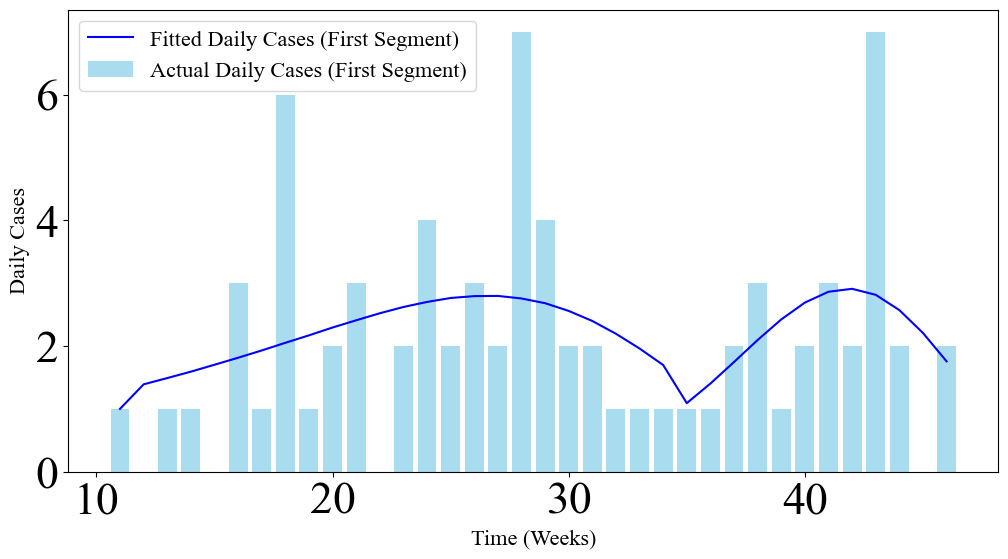

皮尔森相关系数：0.47248435149730306
p值：0.0036173488667520163


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2019, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2019, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Hefei/2019.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2019, result_2019)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

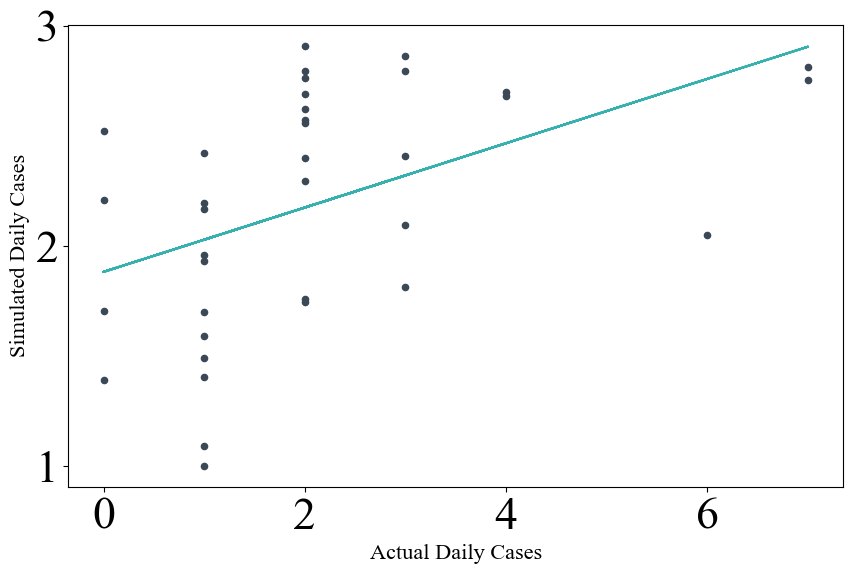

R²：0.223241462409827


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2019)
predicted_cases = np.array(result_2019)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Hefei/2019.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.140346591197408
R_2023 的平均数为: 1.2281500011803228


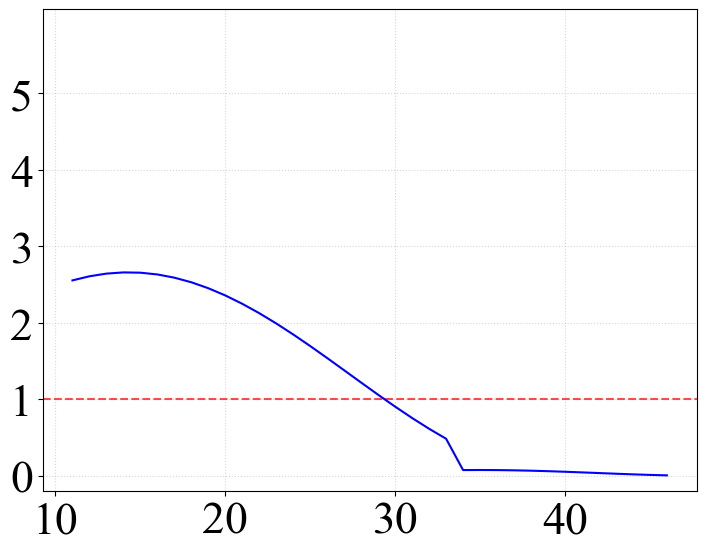

In [ ]:
R_2019 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2019).to_excel('../../outcome/Result/Fit/Hefei/R_2019.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2019)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2019)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 6.1)
plt.yticks(np.arange(0, 5.1, 1)) # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()
plt.plot(np.arange(11, 47), R_2019, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Hefei/R_2019.pdf', format='pdf')
plt.show()